# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders_teacher import MainRecommender # пока беру код преподавателя 

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(2375, N=200)

[899624,
 871756,
 923746,
 1046545,
 1004906,
 844179,
 845208,
 865456,
 981760,
 823704,
 1000753,
 1130858,
 1044078,
 1068719,
 883932,
 965766,
 938138,
 1037863,
 843306,
 870547,
 1116376,
 1092937,
 1069979,
 949965,
 981521,
 9836106,
 9835223,
 12731544,
 12810391,
 12301839,
 896862,
 823990,
 1097458,
 951590,
 925862,
 863447,
 1082185,
 973374,
 1009770,
 951190,
 1051323,
 828106,
 999270,
 984715,
 972931,
 1081177,
 1022827,
 825343,
 12731432,
 1005935,
 9526410,
 947858,
 832678,
 1044068,
 1126895,
 912137,
 5585510,
 6534480,
 963971,
 1134678,
 8065410,
 850925,
 819255,
 962229,
 910032,
 965267,
 898068,
 874972,
 1043590,
 999714,
 896613,
 1039126,
 1106523,
 827919,
 1046689,
 1026984,
 995876,
 957741,
 1131438,
 944534,
 834842,
 1094833,
 1070702,
 847982,
 862799,
 998239,
 1103691,
 1056509,
 998556,
 999858,
 937292,
 1029743,
 999779,
 841220,
 1122115,
 902172,
 963727,
 15926886,
 5568197,
 1041796,
 976335,
 1022428,
 914190,
 1110292,
 948650,
 98

In [6]:
recommender.get_own_recommendations(2375, N=200)

[1036501,
 948640,
 1085983,
 1079023,
 907099,
 910439,
 1005935,
 847962,
 873980,
 884694,
 847066,
 1046689,
 1097422,
 964120,
 1003616,
 969932,
 950935,
 1015474,
 840640,
 974265,
 9521787,
 1072685,
 9527066,
 999104,
 940996,
 945652,
 1125219,
 1102207,
 835300,
 1138243,
 982955,
 1131382,
 1020770,
 989069,
 986021,
 973181,
 827667,
 890719,
 998373,
 9526673,
 1000707,
 916487,
 1038692,
 980433,
 9527494,
 7441873,
 1021715,
 1035842,
 1022340,
 12810472,
 960791,
 1070803,
 1006878,
 1115098,
 1068451,
 6391532,
 927030,
 9677748,
 12757653,
 983078,
 929751,
 973374,
 996269,
 849843,
 828393,
 5570048,
 834631,
 956666,
 1087547,
 1033615,
 947858,
 1115553,
 1023815,
 1033046,
 8160430,
 1121028,
 1082454,
 982833,
 1056492,
 905539,
 1004945,
 13945141,
 1044068,
 1078652,
 937343,
 1058939,
 1092885,
 857006,
 841309,
 1101174,
 1014238,
 932675,
 850102,
 900802,
 7169034,
 951221,
 956599,
 5570408,
 1018740,
 999730,
 1138467,
 984715,
 1044805,
 1096794,
 9952

In [7]:
recommender.get_similar_items_recommendation(2375, N=200)

[1107553,
 1046545,
 845208,
 9527160,
 1106523,
 1090507,
 889731,
 1133018,
 1042907,
 918335,
 824758,
 890610,
 9527161,
 1121367,
 1079067,
 999104,
 962568,
 1134678,
 1002558,
 1043751,
 866211,
 962568,
 923746,
 864048,
 871611,
 878996,
 865528,
 1070702,
 951590,
 825343,
 9835223,
 828106,
 898958,
 1037863,
 863447,
 883068,
 1098066,
 892008,
 906923,
 9521679,
 992529,
 1097458,
 1027090,
 899624,
 12301100,
 999730,
 878996,
 1018740,
 1076875,
 957951,
 879735,
 1067185,
 828106,
 1112238,
 1027068,
 8090537,
 1077133,
 1008032,
 1137688,
 1054424,
 1131438,
 12132277,
 825343,
 843306,
 957839,
 7441210,
 882247,
 948650,
 969977,
 871756,
 925862,
 1008032,
 1042907,
 951590,
 1087547,
 1037863,
 1081189,
 9297156,
 872417,
 1081177,
 9707340,
 1123254,
 8065410,
 909249,
 1136732,
 888532,
 985119,
 979973,
 8090545,
 916487,
 969941,
 1098435,
 8020234,
 1069334,
 1104349,
 1110843,
 859154,
 952163,
 869322,
 1042438,
 985999,
 6602440,
 825970,
 1105301,
 957063,

In [8]:
recommender.get_similar_users_recommendation(2375, N=200)

[917407,
 857130,
 984575,
 997796,
 1057168,
 1015296,
 934948,
 5569135,
 995598,
 943940,
 921345,
 901067,
 847434,
 1012801,
 1082212,
 1139142,
 1093490,
 885356,
 6552318,
 1101502,
 1124971,
 9553048,
 945909,
 6391557,
 948225,
 6979437,
 854133,
 918684,
 5569135,
 963686,
 927325,
 1010190,
 892728,
 945652,
 1096573,
 921406,
 1116050,
 947427,
 9802981,
 1211227,
 873887,
 1025581,
 9392700,
 1096563,
 939681,
 1100379,
 1138292,
 984680,
 1108131,
 937626,
 1028938,
 914577,
 1122255,
 1131506,
 894439,
 982799,
 1069003,
 905087,
 1131344,
 970160,
 884089,
 972416,
 914240,
 1126045,
 1056212,
 1056212,
 924355,
 937403,
 1096261,
 869868,
 1030093,
 837969,
 982211,
 983267,
 997025,
 1118623,
 1055168,
 986187,
 1033615,
 5568758,
 1055425,
 906202,
 914697,
 1036753,
 923149,
 900370,
 1012801,
 835558,
 926422,
 1098025,
 1028422,
 917438,
 835595,
 1102003,
 908843,
 1043920,
 1139569,
 1134296,
 1104349,
 847962,
 886996,
 876806,
 9245108,
 1093697,
 1006664,
 94

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [9]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [10]:
result_lvl_1['ALS_recs'] = 0
result_lvl_1['ALS_recs'] = result_lvl_1['ALS_recs'].astype(object)
# пока оставляю через исключение, как сделала изначально, чтобы видеть все в одном файле (с налету не получилось переделать)
for i in range(result_lvl_1.shape[0]):
    try:
        result_lvl_1.at[i, 'ALS_recs'] = recommender.get_als_recommendations(result_lvl_1['user_id'][i], N=200)
    except IndexError:
        # если пользователя нет в списке, рекомендую популярные товары:
        result_lvl_1.at[i, 'ALS_recs'] = []
        result_lvl_1.at[i, 'ALS_recs'] = recommender._extend_with_top_popular(result_lvl_1['ALS_recs'][i], N=200)
result_lvl_1.head(2)

,user_id,actual,ALS_recs
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1062572, 885290, 1004390, 5569374, 8090513, 8..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[916122, 1042616, 1014458, 9296804, 12518330, ..."


In [11]:
ALS_recall = result_lvl_1.apply(lambda row: recall_at_k(row['ALS_recs'], row['actual'], k=200), axis=1).mean()
ALS_recall

0.15350279329261768

In [12]:
result_lvl_1['own_recs'] = 0
result_lvl_1['own_recs'] = result_lvl_1['own_recs'].astype(object)
for i in range(result_lvl_1.shape[0]):
    try:
        result_lvl_1.at[i, 'own_recs'] = recommender.get_own_recommendations(result_lvl_1['user_id'][i], N=200)
    except ValueError:
        result_lvl_1.at[i, 'own_recs'] = []
        result_lvl_1.at[i, 'own_recs'] = recommender._extend_with_top_popular(result_lvl_1['own_recs'][i], N=200)
result_lvl_1.head(2)

,user_id,actual,ALS_recs,own_recs
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1062572, 885290, 1004390, 5569374, 8090513, 8...","[856942, 9297615, 5577022, 9655212, 1082269, 9..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[916122, 1042616, 1014458, 9296804, 12518330, ...","[1076580, 911974, 5567582, 1070803, 1007414, 1..."


In [13]:
own_recall = result_lvl_1.apply(lambda row: recall_at_k(row['own_recs'], row['actual'], k=200), axis=1).mean()
own_recall

0.20385412367052688

In [14]:
%%time
result_lvl_1['similar_items_recs'] = 0
result_lvl_1['similar_items_recs'] = result_lvl_1['similar_items_recs'].astype(object)
for i in range(result_lvl_1.shape[0]):
    result_lvl_1.at[i, 'similar_items_recs'] = recommender.get_similar_items_recommendation(result_lvl_1['user_id'][i], N=200)
    
result_lvl_1.head(2)

Wall time: 43.3 s


,user_id,actual,ALS_recs,own_recs,similar_items_recs
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1062572, 885290, 1004390, 5569374, 8090513, 8...","[856942, 9297615, 5577022, 9655212, 1082269, 9...","[824758, 826249, 9526411, 1007512, 9297615, 55..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[916122, 1042616, 1014458, 9296804, 12518330, ...","[1076580, 911974, 5567582, 1070803, 1007414, 1...","[8090537, 5569845, 1106523, 1133018, 985999, 8..."


In [15]:
similar_items_recall = result_lvl_1.apply(lambda row: recall_at_k(row['similar_items_recs'], row['actual'], k=200), axis=1).mean()
similar_items_recall

0.12964624916362763

In [16]:
%%time
# занимает около получаса!!!
result_lvl_1['similar_users_recs'] = 0
result_lvl_1['similar_users_recs'] = result_lvl_1['similar_users_recs'].astype(object)
for i in range(result_lvl_1.shape[0]):
    try:
        result_lvl_1.at[i, 'similar_users_recs'] = recommender.get_similar_users_recommendation(result_lvl_1['user_id'][i], N=200)
    except IndexError:
        result_lvl_1.at[i, 'similar_users_recs'] = []
        result_lvl_1.at[i, 'similar_users_recs'] = recommender._extend_with_top_popular(result_lvl_1['similar_users_recs'][i], N=200)
    except ValueError:
        result_lvl_1.at[i, 'similar_users_recs'] = []
        result_lvl_1.at[i, 'similar_users_recs'] = recommender._extend_with_top_popular(result_lvl_1['similar_users_recs'][i], N=200)
result_lvl_1.head(2)

Wall time: 31min 2s


,user_id,actual,ALS_recs,own_recs,similar_items_recs,similar_users_recs
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1062572, 885290, 1004390, 5569374, 8090513, 8...","[856942, 9297615, 5577022, 9655212, 1082269, 9...","[824758, 826249, 9526411, 1007512, 9297615, 55...","[1036753, 1029743, 1048257, 9296804, 918046, 1..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[916122, 1042616, 1014458, 9296804, 12518330, ...","[1076580, 911974, 5567582, 1070803, 1007414, 1...","[8090537, 5569845, 1106523, 1133018, 985999, 8...","[1029743, 1082185, 995242, 1106523, 1133018, 1..."


In [17]:
similar_users_recall = result_lvl_1.apply(lambda row: recall_at_k(row['similar_users_recs'], row['actual'], k=200), axis=1).mean()
similar_users_recall

0.04876762749621414

Видим, что наилучший recall у предсказания по собственным покупкам, затем ALS, потом рекомендации по cхожести товаров. Рекомендации по схожим пользователям считаются очень долго и дают минимальный результат.

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}

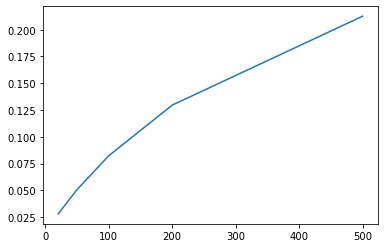

In [18]:
k_list = [20, 50, 100, 200, 500]
k_recall = []

for el in k_list:
    result_lvl_1[f'similar_items_recs_{el}'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=el))
    k_recall_el = result_lvl_1.apply(lambda row: recall_at_k(row[f'similar_items_recs_{el}'], row['actual'], k=el), axis=1).mean()
    k_recall.append(k_recall_el)

plt.plot(k_list, k_recall)

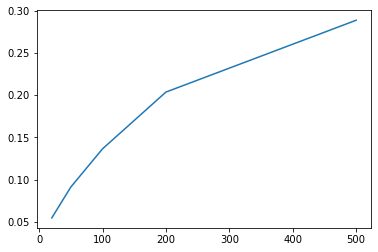

In [19]:
k_recall = []

for el in k_list:
    result_lvl_1[f'own_recs_{el}'] = 0
    result_lvl_1[f'own_recs_{el}'] = result_lvl_1[f'own_recs_{el}'].astype(object)
    for i in range(result_lvl_1.shape[0]):
        try:
            result_lvl_1.at[i, f'own_recs_{el}'] = recommender.get_own_recommendations(result_lvl_1['user_id'][i], N=el)
        except ValueError:
            result_lvl_1.at[i, f'own_recs_{el}'] = []
            result_lvl_1.at[i, f'own_recs_{el}'] = recommender._extend_with_top_popular(result_lvl_1['own_recs'][i], N=el)
    
    k_recall_el = result_lvl_1.apply(lambda row: recall_at_k(row[f'own_recs_{el}'], row['actual'], k=el), axis=1).mean()
    k_recall.append(k_recall_el)

plt.plot(k_list, k_recall)

C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

Видим, что recall_at_k растет вместе с возрастанием значения k, что логично, так как расширяем число рекомендаций (если будем рекомендовать все товары, recall формально будет 100%). На значении 200 видим "колено", темп роста замедляется. Поэтому предполагаю, что 200 является оптимальным числом кандидиатов.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [20]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

# есть ли смысл рекоммендовать то, что пользователь и так знает и купит, если понравилось? но пока оставляю, чтобы сравнить
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))

# товары из 200 кандидатов:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['drop'] = 1  # фиктивная переменная

#users_lvl_2['user_id'].nunique()

targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('drop', axis=1, inplace=True)

In [21]:
targets_lvl_2['target'].mean()

0.08645494612569538

In [22]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.shape

(441305, 16)

Генерация фичей

In [23]:
# средний чек
users_sales = data.groupby('user_id')['sales_value'].sum().reset_index()
num_baskets = data.groupby('user_id')['basket_id'].nunique().reset_index()
users_sales = users_sales.merge(num_baskets, on='user_id', how='left')
users_sales['mean_cheque'] = users_sales['sales_value'] / users_sales['basket_id']
users_sales.drop(['sales_value', 'basket_id'], axis=1, inplace=True)
users_sales.head(2)

,user_id,mean_cheque
0,1,50.125443
1,2,41.442045


In [24]:
targets_lvl_2 = targets_lvl_2.merge(users_sales, on='user_id', how='left')
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_cheque
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937


In [25]:
# средний чек по категории
departments = list(set(targets_lvl_2['department'].tolist()))
departments

['SEAFOOD',
 'CHEF SHOPPE',
 'DELI',
 'SALAD BAR',
 'NUTRITION',
 'MISC SALES TRAN',
 'GROCERY',
 'TRAVEL & LEISUR',
 'PASTRY',
 'DRUG GM',
 'GARDEN CENTER',
 'SEAFOOD-PCKGD',
 'SPIRITS',
 'FLORAL',
 'MEAT-PCKGD',
 'MEAT',
 'PRODUCE',
 'MISC. TRANS.',
 'RESTAURANT',
 'AUTOMOTIVE',
 'KIOSK-GAS',
 'COSMETICS']

In [26]:
%%time
targets_lvl_2['mean_department_price'] = 0

for n in departments:
    dep_targets_lvl_2 = targets_lvl_2[targets_lvl_2['department'] == n]
    ids = dep_targets_lvl_2['item_id'].tolist()
    dep_data = data[data['item_id'].isin(ids)]
    
    dep_sales = dep_data.groupby('user_id').agg({
    'sales_value' : 'sum', 
    'quantity': 'sum'}).reset_index()
    
    dep_sales['dep_mean_price'] = dep_sales['sales_value'] / dep_sales['quantity']
    dep_sales.drop(['sales_value', 'quantity'], axis=1, inplace=True)
    
    for i in range(dep_sales.shape[0]):
        targets_lvl_2.loc[(((targets_lvl_2['user_id'] == dep_sales['user_id'][i]) & (targets_lvl_2['department'] == n)) == True), 'mean_department_price'] = dep_sales['dep_mean_price'][i]

targets_lvl_2.head(2)

Wall time: 10min 49s


,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_cheque,mean_department_price
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,1.86138
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,1.86138


In [27]:
# Кол-во покупок в неделю (не все товары продавались полный срок, поэтому включаю число недель продажи)
week_sales = data.groupby('item_id').agg({ 
    'quantity': 'sum',
    'week_no' : 'nunique'
}).reset_index()
week_sales['item_id_week_sales'] = week_sales['quantity'] / week_sales['week_no']
week_sales.drop(['quantity', 'week_no'], axis=1, inplace=True)
week_sales.head()

,item_id,item_id_week_sales
0,25671,2.0
1,26081,1.0
2,26093,1.0
3,26190,1.0
4,26355,2.0


In [28]:
targets_lvl_2 = targets_lvl_2.merge(week_sales, on='item_id', how='left')
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_cheque,mean_department_price,item_id_week_sales
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,1.86138,6.744444
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,1.86138,6.744444


In [29]:
# Цена
mean_price = data.groupby('item_id').agg({
    'sales_value' : 'sum', 
    'quantity': 'sum'
}).reset_index()

mean_price['mean_price'] = mean_price['sales_value'] / mean_price['quantity']

mean_price.drop(['sales_value', 'quantity'], axis=1, inplace=True)

mean_price.head(2)

,item_id,mean_price
0,25671,3.49
1,26081,0.99


In [30]:
targets_lvl_2 = targets_lvl_2.merge(mean_price, on='item_id', how='left')
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_cheque,mean_department_price,item_id_week_sales,mean_price
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,1.86138,6.744444,1.092059
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,1.86138,6.744444,1.092059


In [32]:
# Средняя сумма покупки юзером 1 товара в каждой категории - Средняя цена в этой категории
# выполняется около 30 минут (здесь и нижк почему-то вылетает UsageError: Line magic function `%%time` not found.)
#%%time
targets_lvl_2['delta_dep_user_price'] = 0

for n in departments:
    dep_targets_lvl_2 = targets_lvl_2[targets_lvl_2['department'] == n]
    ids = dep_targets_lvl_2['item_id'].tolist()
    dep_data = data[data['item_id'].isin(ids)]
    
    dep_mean_price = dep_data['sales_value'].sum() / dep_data['quantity'].sum()
    
    dep_user_sales = data.groupby('user_id').agg({
    'sales_value' : 'sum', 
    'quantity': 'sum'}).reset_index()
    
    dep_user_sales['mean_dep_user_price'] = dep_user_sales['sales_value'] / dep_user_sales['quantity']
    dep_user_sales.drop(['sales_value', 'quantity'], axis=1, inplace=True)
    
    for i in range(dep_user_sales.shape[0]):
        targets_lvl_2.loc[(((targets_lvl_2['user_id'] == dep_user_sales['user_id'][i]) &
                            (targets_lvl_2['department'] == n)) == True), 'delta_dep_user_price'] = dep_user_sales['mean_dep_user_price'][i] - dep_mean_price

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_cheque,mean_department_price,item_id_week_sales,mean_price,delta_dep_user_price
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,1.86138,6.744444,1.092059,-2.151125
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,1.86138,6.744444,1.092059,-2.151125


In [33]:
# (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю). 
# выполняется около 30 минут
#%%time
targets_lvl_2['rel_week_sales'] = 0

for n in departments:
    dep_targets_lvl_2 = targets_lvl_2[targets_lvl_2['department'] == n]
    ids = dep_targets_lvl_2['item_id'].tolist()
    dep_data = data[data['item_id'].isin(ids)]
    
    dep_mean_week_sales = dep_data['quantity'].sum() / dep_data['week_no'].nunique()
    
    dep_user_week_sales = data.groupby('user_id').agg({ 
    'quantity': 'sum',
    'week_no' : 'nunique'
    }).reset_index()
    
    dep_user_week_sales['mean_user_week_sales'] = dep_user_week_sales['quantity'] / dep_user_week_sales['week_no']
    dep_user_week_sales.drop(['quantity', 'week_no'], axis=1, inplace=True)
    
    for i in range(dep_user_week_sales.shape[0]):
        targets_lvl_2.loc[(((targets_lvl_2['user_id'] == dep_user_week_sales['user_id'][i]) &
                            (targets_lvl_2['department'] == n)) == True), 'rel_week_sales'] = dep_user_week_sales['mean_user_week_sales'][i] / dep_mean_week_sales

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_cheque,mean_department_price,item_id_week_sales,mean_price,delta_dep_user_price,rel_week_sales
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,12.92937,1.86138,6.744444,1.092059,-2.151125,0.142563
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,12.92937,1.86138,6.744444,1.092059,-2.151125,0.142563


# Обучение 2 уровня

In [34]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [35]:
cat_feats = X_train.columns[2:15].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [36]:
%%time

lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

# предсказываем на том же датасете и добавляем предказания (массив из 1 и 0) в targets_lvl_2
train_preds = lgb.predict(X_train)
train_preds[:5]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Wall time: 3.32 s


array([1., 1., 1., 1., 1.])

In [37]:
targets_lvl_2['preds'] = train_preds

In [38]:
# собираем по пользователям
lgb_recs = targets_lvl_2.groupby('user_id').head(5).groupby('user_id')['item_id'].unique().reset_index()
lgb_recs.head()

,user_id,item_id
0,1,"[856942, 9297615, 5577022]"
1,2,"[1076580, 911974, 5567582, 1070803, 1007414]"
2,4,"[6391541, 891423, 936470, 1137010, 910109]"
3,6,"[13003092, 995598, 9911484, 972416, 1108094]"
4,7,"[896666, 7147142, 9338009, 998519, 939681]"


In [39]:
# так же собираем валидационную выборку
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head()

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."


In [40]:
result_lvl_2 = result_lvl_2.merge(lgb_recs, on='user_id', how='left')
result_lvl_2.rename(columns={'item_id': 'lgb_recs'}, inplace=True)
result_lvl_2.head()

,user_id,actual,lgb_recs
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 9297615, 5577022]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[13003092, 995598, 9911484, 972416, 1108094]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[896666, 7147142, 9338009, 998519, 939681]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[981660, 969932, 1105433, 12808385, 829722]"


In [41]:
# precision 1 уровня
own_precision_val_1 = result_lvl_1.apply(lambda row: precision_at_k(row['own_recs'], row['actual'], k=200), axis=1).mean()
own_precision_val_1

0.06326369545032515

In [42]:
# precision на пользователях, для которых модель рассчитала val2
result_lvl_2[result_lvl_2.lgb_recs.notna()].\
apply(lambda row: precision_at_k(row['lgb_recs'], row['actual'], k=5), axis=1).mean()

0.23308093994777906

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - money precision@5. Порог для уcпешной сдачи проекта money precision@5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- **2 новых товара** (юзер никогда не покупал)
- **1 дорогой товар, > 7 долларов**
- **Все товары из разных категорий** (категория - department)  
- **Стоимость каждого рекомендованного товара > 1 доллара**  

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и .csv файл с рекомендациями. В .csv файле 2 столбца: user_id - (item_id1, item_id2, ..., item_id5)